In [55]:
import torch
import torchvision.datasets as dset
import torchvision.transforms as transforms

from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import torchvision.utils

import torch.nn as nn
import torch.nn.functional as f 

import numpy as np
import random
from PIL import Image
from torch.autograd import Variable

from torch import optim

In [2]:
class Config():
    training_dir = r"C:\Users\mistr\OneDrive\Documents\Thesis\Codes\Siamese_Network\data\train"
    testing_dir = r"C:\Users\mistr\OneDrive\Documents\Thesis\Codes\Siamese_Network\data\test"
    train_batch_size = 16
    train_number_epochs = 50

In [3]:
class SN(nn.Module):
    def __init__(self):
        super(SN,self).__init__()
        self.cnn1 = nn.Sequential(                  # Easy way to initialize a network instead of making layer objects everytime
        nn.ReflectionPad2d(1),                                #Padding the image with a reflection across all the dimensions 
        nn.Conv2d(in_channels = 1, out_channels = 4,kernel_size = 3),
        nn.ReLU(inplace = True),
            
        nn.ReflectionPad2d(1),                                      
        nn.Conv2d(in_channels = 4, out_channels = 8, kernel_size = 3),
        nn.ReLU(inplace = True),
            
        nn.ReflectionPad2d(1),
        nn.Conv2d(in_channels = 8, out_channels = 8, kernel_size = 3),
        nn.ReLU(inplace = True)
            
        )
        
        self.fc1 = nn.Sequential(
        nn.Linear(in_features = 8*100*100, out_features = 500),
        nn.ReLU(inplace = True),
        nn.Linear(in_features = 500, out_features=500),
        nn.ReLU(inplace = True),
        nn.Linear(in_features= 500, out_features=5)
        )
        
    def forward_once(self,t):
        """
        Making a single pass to the whole network
        """
        output = self.cnn1(t)
        output = output.view(output.size()[0], -1)                        #Memory efficient reshaping of the tensor
        output = self.fc1(output)
        return output
    
    
    def forward(self, input1, input2):
        """
        The sister networks must have the same set of weights and hence instead of creating two different networks we
        make two passes through the network. 
        """
        output1 = self.forward_once(input1)                                    # Image 1 passes through the network
        output2 = self.forward_once(input2)                                    # Image 2 passes through the network
        return output1,output2
        

In [4]:
class SMDataset(Dataset):
    """
    The abstract class that is supposed to be implemented for creating a custom dataset in python. This dataset generates a pair
    of images. "0" creates a genuine pair, i.e images from the same class/folder whereas "1" creates a imposter pair, different classes.
    """
    def __init__(self, imageFolderDataset, transform = None, should_invert = True):
        self.imageFolderDataset = imageFolderDataset
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self, index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        
        should_get_same_class = random.randint(0,1)        # images generated are equally genuine and imposter pairs for learning
        if should_get_same_class:
            while True:
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img1_tuple[1] == img0_tuple[1]:              # making sure that they belong to the same class
                    break
                
        else:
            while True:
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img1_tuple[1]!= img0_tuple:                      # making sure that they belong to the diff class
                    break
                    
        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")

        #Based on the arguments given in the function defintion
        if self.should_invert: 
                img0 = PIL.ImageOps.invert(img0)
                img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
                img0 = self.transform(img0)
                img1 = self.transform(img1)

        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
        # returning the image pair and whether the pair is 0(genuine pair) or 1(imposter pair)
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)
    
    

In [5]:
#ImageFolder object that holds the data
folder_dataset = dset.ImageFolder(root = Config.training_dir)

In [6]:
#Instantiating the dataset for the network and also applying the transforms of resizing and tensor conversion. 

siamese_dataset = SMDataset(imageFolderDataset = folder_dataset, 
                            transform = transforms.Compose([transforms.Resize((100,100)),
                                                            transforms.ToTensor()]),
                            should_invert=False) 

In [7]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # it accepts image only in a certain format
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

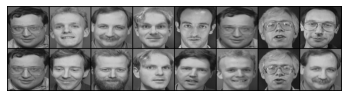

[[0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]]


In [9]:
    viz_dataloader = DataLoader(siamese_dataset, shuffle = True, num_workers = 0, batch_size = 8)
    viz_data = iter(viz_dataloader)

    ex_batch = next(viz_data)
    concatenated = torch.cat((ex_batch[0],ex_batch[1]),dim = 0)
    imshow(torchvision.utils.make_grid(concatenated))
    print(ex_batch[2].numpy())
    

In [10]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function implemetation
    
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = f.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [11]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=0,
                        batch_size=Config.train_batch_size)


In [12]:
net = SN().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

In [13]:
counter = []
loss_history = [] 
iteration_number= 0

Epoch number 0
 Current loss 1.7469539642333984

Epoch number 0
 Current loss 0.6797124147415161

Epoch number 0
 Current loss 0.4717811048030853

Epoch number 1
 Current loss 0.7705959677696228

Epoch number 1
 Current loss 0.45734208822250366

Epoch number 1
 Current loss 0.24892936646938324

Epoch number 2
 Current loss 0.3928282856941223

Epoch number 2
 Current loss 0.3122507333755493

Epoch number 2
 Current loss 0.25910863280296326

Epoch number 3
 Current loss 0.26274779438972473

Epoch number 3
 Current loss 0.33398526906967163

Epoch number 3
 Current loss 0.3732434809207916

Epoch number 4
 Current loss 0.4137679934501648

Epoch number 4
 Current loss 0.16702409088611603

Epoch number 4
 Current loss 0.49965330958366394

Epoch number 5
 Current loss 0.3398318290710449

Epoch number 5
 Current loss 0.29247841238975525

Epoch number 5
 Current loss 0.16695216298103333

Epoch number 6
 Current loss 0.19477427005767822

Epoch number 6
 Current loss 0.18052828311920166

Epoch num

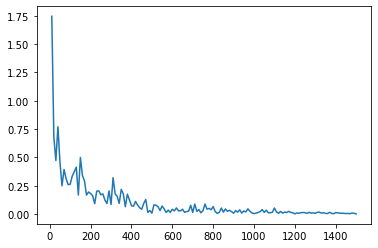

In [14]:
for epoch in range(0,Config.train_number_epochs):
    for i, data in enumerate(train_dataloader,0):
        if torch.cuda.is_available():
            img0, img1 , label = data
            img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
            optimizer.zero_grad()
            output1,output2 = net(img0,img1)
            loss_contrastive = criterion(output1,output2,label)
            loss_contrastive.backward()
            optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
show_plot(counter,loss_history)

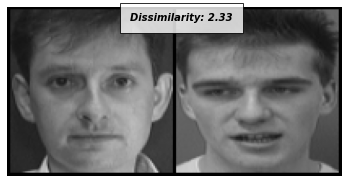

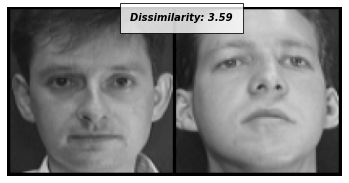

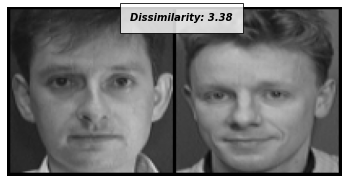

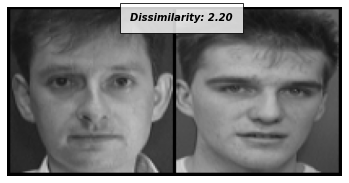

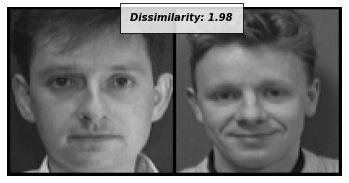

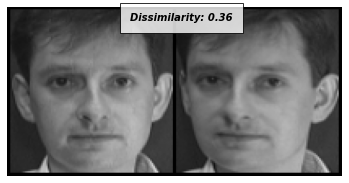

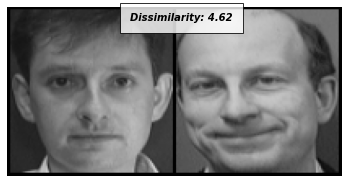

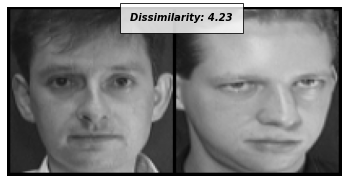

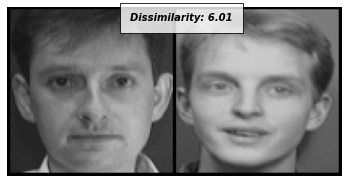

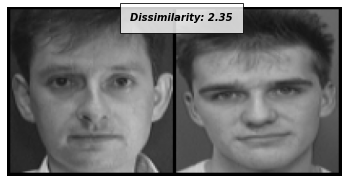

In [57]:
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset = SMDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=0,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)

for i in range(10):
    _,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    
    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = f.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))

In [50]:
df_img.reshape(100,100)
real_img.reshape(100,100)

tensor([[0.4902, 0.4902, 0.4863,  ..., 0.4471, 0.4471, 0.4471],
        [0.4941, 0.4902, 0.4824,  ..., 0.4588, 0.4627, 0.4627],
        [0.4980, 0.4902, 0.4784,  ..., 0.4510, 0.4745, 0.4902],
        ...,
        [0.1059, 0.1059, 0.1059,  ..., 0.7373, 0.7294, 0.7216],
        [0.1020, 0.1020, 0.1020,  ..., 0.7333, 0.7176, 0.7059],
        [0.1020, 0.1020, 0.1020,  ..., 0.7294, 0.7137, 0.6431]])

In [53]:
# output1, output2 = net(df_img, real_img)

AssertionError: 3D tensors expect 2 values for padding

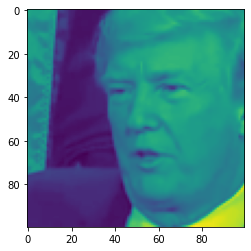

In [43]:
df_1 = Image.open(r"C:\Users\mistr\OneDrive\Desktop\df01604.jpg")
df_1 = df_1.convert('L')
real_1 = Image.open(r"C:\Users\mistr\OneDrive\Desktop\real03611.jpg")
real_1 = real_1.convert('L')
trans = transforms.Compose([transforms.Resize((100,100)), transforms.ToTensor()])
df_img = trans(df_1)
real_img = trans(real_1)


plt.imshow(df_img.reshape(100,100))

plt.imshow(real_img.reshape(100,100))